In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib as mpl

plt.style.use(["seaborn", "thesis"])

/home/jo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
plt.rc("figure", figsize=(8,4))

# Data 

In [3]:
from SCFInitialGuess.utilities.dataset import Data

target = "P"
basis = "6-311++g**"

data = Data()
data.include(data_path = "../../thesis/dataset/EthanT/", postfix = "EthanT", target=target)

In [4]:
from SCFInitialGuess.utilities.dataset import Molecule

angle_HCC = 121.3/180 *np.pi
distance_CC = 1.339
distance_CH = 1.087

mol = Molecule(
    species=["C", "C", "H", "H", "H", "H"],
    positions=[
        [ 0.00000,       0.00000,        0.00000],
        [ distance_CC  ,       0.00000,        0.00000],
        [ distance_CH * np.cos(angle_HCC), distance_CH * np.sin(angle_HCC), 0.00000],
        [ distance_CH * np.cos(2*np.pi - angle_HCC), distance_CH * np.sin(2*np.pi - angle_HCC), 0.00000],
        [ distance_CC + distance_CH * np.cos(np.pi - angle_HCC), distance_CH * np.sin(np.pi - angle_HCC), 0.00000],
        [ distance_CC + distance_CH * np.cos(- np.pi + angle_HCC), distance_CH * np.sin(- np.pi + angle_HCC), 0.00000]
    ]
)

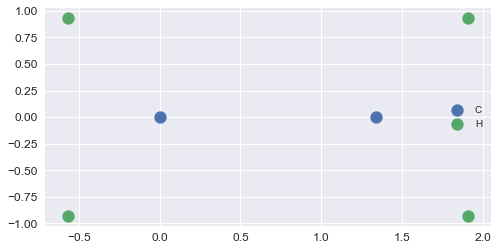

In [5]:
#%matplotlib inline

pos = np.array(mol.positions)

plt.scatter(pos[:2, 0], pos[:2, 1], label="C")
plt.scatter(pos[2:, 0], pos[2:, 1], label="H")
plt.legend()

# Descriptor 

In [6]:
from SCFInitialGuess.descriptors.high_level import AtomicNumberWeighted
from SCFInitialGuess.descriptors.coordinate_descriptors import \
    SphereSectionDescriptor, ConstantAngularDescriptor, Gaussians
from SCFInitialGuess.descriptors.cutoffs import BehlerCutoff1
from SCFInitialGuess.descriptors.models import make_uniform

model = make_uniform(8, R_c=3.5, R_min=1.0, eta_max=100)#, eta_min=80)

radial = Gaussians(*model)

descriptor = AtomicNumberWeighted(
    ConstantAngularDescriptor(),
    SphereSectionDescriptor(
        number_azimuthal_sections=8,
        number_polar_sections=4,
        radial_descriptor=radial
    ),
    BehlerCutoff1(5)
)
    

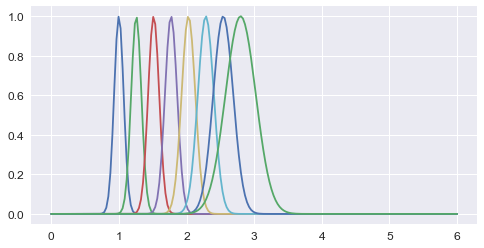

In [7]:
from SCFInitialGuess.descriptors.utilities import plot_normal_model

#%matplotlib inline

plot_normal_model(model, np.linspace(0, 6, 200))

# Calculate Dataset for C

In [8]:
G = descriptor.calculate_atom_descriptor(
    index_atom=1, 
    molecule=mol, 
    number_of_descriptors=descriptor.number_of_descriptors
)

<Container object of 256 artists>

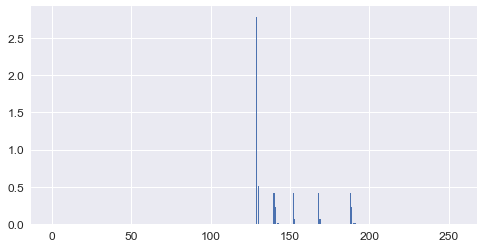

In [9]:
plt.bar(np.arange(len(G)), G)

# Activation 

In [10]:
n = 100

r = np.linspace(0, 6, n)
phi = np.linspace(0, 2*np.pi, n)
theta = np.pi/2

R, Phi = np.meshgrid(r, phi)

R = R.reshape(-1)
Phi = Phi.reshape(-1)

## Radial 

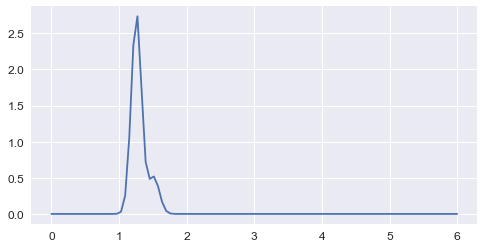

In [11]:
plt.plot(r, descriptor.angular_descriptor.calculate_inverse_descriptor(r, phi=0.0, theta=np.pi/2, y=G).reshape(-1))

## Angles, z=0

In [12]:
R.shape, Phi.shape

((10000,), (10000,))

In [13]:
z = descriptor.angular_descriptor.calculate_inverse_descriptor(
    r=r, 
    phi=phi, 
    theta=theta, 
    y=G
)#.reshape(-1)

z[z==0] = 1e-20

z.shape

(1, 100, 100)

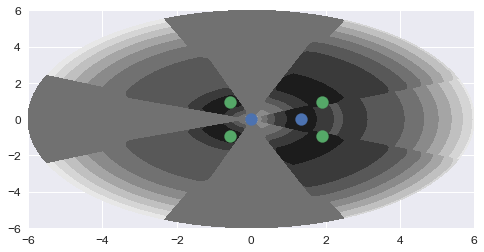

In [14]:
plt.contourf(
    (R * np.cos(Phi)).reshape(n, n),
    (R * np.sin(Phi)).reshape(n, n),
    z.reshape(n, n),
    locator=mpl.ticker.LogLocator()
)

plt.scatter(pos[:2, 0], pos[:2, 1], label="C")
plt.scatter(pos[2:, 0], pos[2:, 1], label="H")


## Angles, Spheres 

In [15]:
n = 100

r = 2
phi = np.linspace(0, 2*np.pi, n)
theta = np.linspace(0, np.pi, n)

Phi, Theta = np.meshgrid(phi, theta)

In [16]:
z = descriptor.angular_descriptor.calculate_inverse_descriptor(
    r=r, 
    phi=phi, 
    theta=theta, 
    y=G
)#.reshape(-1)

z[z==0] = 1e-20

z.shape

(100, 100, 1)

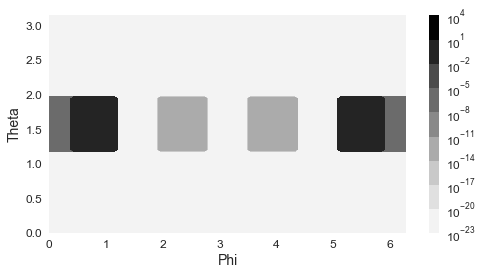

In [17]:
plt.contourf(
    Phi, 
    Theta,
    z.reshape(n, n),
    locator=mpl.ticker.LogLocator()
)
plt.xlabel("Phi")
plt.ylabel("Theta")
plt.colorbar()

In [18]:
#%matplotlib notebook

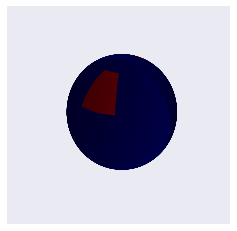

In [19]:
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D

fcolors = z.reshape(n,n)
fmax, fmin = fcolors.max(), fcolors.min()
fcolors = (fcolors - fmin)/(fmax - fmin)

x = np.sin(Phi) * np.cos(Theta)
y = np.sin(Phi) * np.sin(Theta)
z = np.cos(Phi)

# Set the aspect ratio to 1 so our sphere looks spherical
fig = plt.figure(figsize=plt.figaspect(1.))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(
    x, 
    y, 
    z,  
    rstride=1, 
    cstride=1, 
    facecolors=cm.seismic(fcolors)
)
# Turn off the axis planes
ax.set_axis_off()
plt.show()

# Calculate The Dataset 

In [20]:
from SCFInitialGuess.utilities.dataset import make_center_block_dataset

dataset = make_center_block_dataset(
    descriptor,
    data.molecules,
    data.T,
    "C",
    normalize_output=True
)

In [21]:
dataset.testing[0].shape, dataset.testing[1].shape

((402, 256), (402, 253))

# Visualize The Descriptor 

In [22]:
from SCFInitialGuess.utilities.dataset import AbstractDataset

x_train = AbstractDataset.denormalize(dataset.training[0], dataset.x_mean, dataset.x_std)
y_train = dataset.training[1]
np.mean(x_train[0] - x_train[-1])

-0.00227969412752458

## Varaince

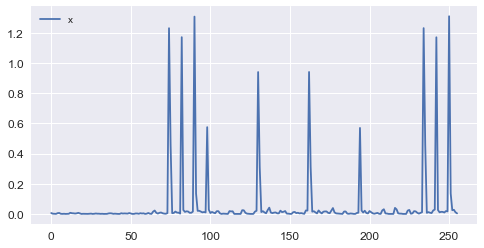

In [23]:
offset=0
plt.plot(np.var(x_train, 0)[offset:], label="x")
#plt.plot([descriptor.radial_descriptor.number_of_descriptors - offset]*2, [1e-3, 1.6], "--")

plt.legend()

## Average 

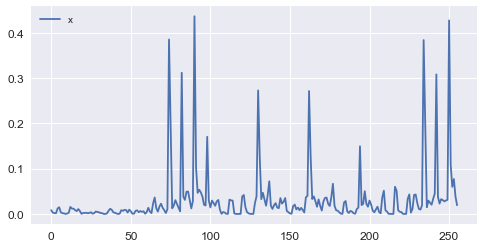

In [24]:
plt.plot(np.mean(x_train, 0), label="x")
#plt.plot([descriptor.radial_descriptor.number_of_descriptors]*2, [-0.25, 0.25], "--")

plt.legend()

## PCA 

### Input 

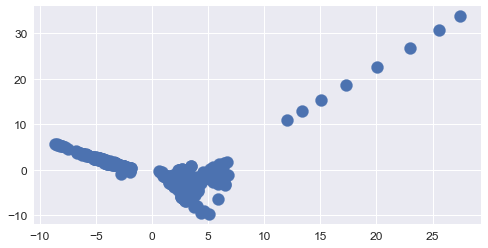

In [25]:
from sklearn.decomposition import PCA

X = dataset.testing[0]

pca = PCA(n_components=2)
pca.fit(X)

x = pca.transform(X)

plt.scatter(x[:,0], x[:, 1])

### Output 

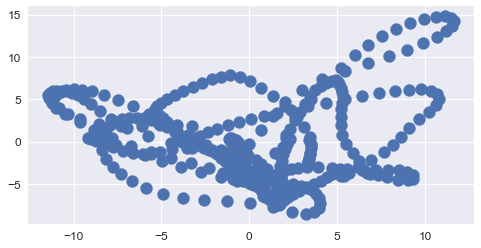

In [26]:
from sklearn.decomposition import PCA

X = dataset.testing[1]

pca = PCA(n_components=2)
pca.fit(X)

x = pca.transform(X)

plt.scatter(x[:,0], x[:, 1])

# Cov 

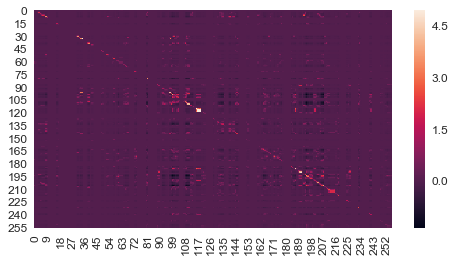

In [28]:
sns.heatmap(
    np.cov(dataset.testing[0].transpose())
)

# Try to Learn

## Utils 

In [29]:
#keras.backend.clear_session()

#activation = "elu"
#learning_rate = 1e-5

intializer = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.01)

def make_model(
        structure, 
        input_dim, 
        output_dim,
        activation="elu", 
        learning_rate=1e-3
    ):

    model = keras.Sequential()

    # input layer
    model.add(keras.layers.Dense(
        structure[0], 
        activation=activation, 
        input_dim=input_dim, 
        kernel_initializer=intializer
    ))

    for layer in structure[1:]:
        model.add(keras.layers.Dense(
            layer, 
            activation=activation, 
            kernel_initializer=intializer, 
            #bias_initializer='zeros',
            kernel_regularizer=keras.regularizers.l2(5e-3)
        ))

    #output
    model.add(keras.layers.Dense(output_dim))

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate), 
        loss='MSE', 
        metrics=['mse']
    )
    
    return model



In [30]:

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_mean_squared_error", 
    min_delta=1e-8, 
    patience=20, 
    verbose=1
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_mean_squared_error', 
    factor=0.1, 
    patience=3, 
    verbose=1, 
    mode='auto', 
    min_delta=1e-6, 
    cooldown=2, 
    min_lr=1e-10
)


epochs = 1000


def train_model(model, dataset, filepath, learning_rate=1e-4, log_dir="./logs"):

    
    tensorboard = keras.callbacks.TensorBoard(
        log_dir=log_dir, 
        histogram_freq=0, 
        batch_size=32, 
        #update_freq='epoch'
    )
    
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, 
        monitor='val_mean_squared_error', 
        verbose=1, 
        save_best_only=True, 
        save_weights_only=False, 
        mode='auto', 
        period=1
    )
    
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    
    train, validation = [], []
    while True:
        keras.backend.set_value(model.optimizer.lr, learning_rate)
            
        history = model.fit(
            x = dataset.training[0],
            y = dataset.training[1],
            epochs=epochs,
            shuffle=True,
            validation_data=dataset.validation, 
            verbose=1, 
            callbacks=[
                early_stopping, 
                reduce_lr,
                #checkpoint,
                #tensorboard
            ]
        )
            
        
        #error.append(model.evaluate(
        #    dataset.testing[0], 
        #    dataset.testing[1], 
        #    verbose=1
        #)[1])
    
    return error
    

## Setup network 

In [31]:
len(dataset.training[0]), len(dataset.validation[0]), len(dataset.testing[0]), 

(1280, 320, 402)

In [32]:
from SCFInitialGuess.utilities.constants import number_of_basis_functions as N_BASIS

species = "C"

dim = N_BASIS[basis][species]
dim_triu = dim * (dim + 1) // 2

descriptor.number_of_descriptors, dim_triu

(256, 253)

In [33]:
keras.backend.clear_session()

In [34]:
structure = [descriptor.number_of_descriptors, dim_triu, dim_triu]

model = make_model(
    structure=structure,
    input_dim=descriptor.number_of_descriptors,
    output_dim=dim_triu,
    
)

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
dense_1 (Dense)              (None, 253)               65021     
_________________________________________________________________
dense_2 (Dense)              (None, 253)               64262     
_________________________________________________________________
dense_3 (Dense)              (None, 253)               64262     
Total params: 259,337
Trainable params: 259,337
Non-trainable params: 0
_________________________________________________________________


## Train network 

Train on 1280 samples, validate on 320 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/1000
1280/1280 [==============================] - 1s 699us/sample - loss: 1.0620 - mean_squared_error: 1.0264 - val_loss: 1.0914 - val_mean_squared_error: 1.0676
Epoch 2/1000
1280/1280 [==============================] - 0s 117us/sample - loss: 1.0399 - mean_squared_error: 1.0224 - val_loss: 1.0806 - val_mean_squared_error: 1.0670
Epoch 3/1000
1280/1280 [==============================] - 0s 108us/sample - loss: 0.9905 - mean_squared_error: 0.9735 - val_loss: 1.1022 - val_mean_squared_error: 1.0819
Epoch 4/1000
1280/1280 [==============================] - 0s 114us/sample - loss: 0.9449 - mean_squared_error: 0.9241 - val_loss: 1.1081 - val_mean_squared_error: 1.0873
Epoch 5/1000
1184/1280 [==========================>...] - ETA: 0s - loss: 0.9276 - mean_squared_error: 0.9052
Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
1280/1280 [========================

 992/1280 [======================>.......] - ETA: 0s - loss: 0.8547 - mean_squared_error: 0.8250
Epoch 00016: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.
1280/1280 [==============================] - 0s 116us/sample - loss: 0.8488 - mean_squared_error: 0.8191 - val_loss: 1.1390 - val_mean_squared_error: 1.1093
Epoch 17/1000
1280/1280 [==============================] - 0s 107us/sample - loss: 0.8488 - mean_squared_error: 0.8191 - val_loss: 1.1390 - val_mean_squared_error: 1.1093
Epoch 18/1000
1280/1280 [==============================] - 0s 107us/sample - loss: 0.8488 - mean_squared_error: 0.8191 - val_loss: 1.1390 - val_mean_squared_error: 1.1093
Epoch 19/1000
1280/1280 [==============================] - 0s 110us/sample - loss: 0.8488 - mean_squared_error: 0.8191 - val_loss: 1.1390 - val_mean_squared_error: 1.1093
Epoch 20/1000
1120/1280 [=========================>....] - ETA: 0s - loss: 0.8480 - mean_squared_error: 0.8183
Epoch 00020: ReduceLROnPlateau reducing l

Epoch 11/1000
1280/1280 [==============================] - 0s 112us/sample - loss: 0.7760 - mean_squared_error: 0.7384 - val_loss: 1.1657 - val_mean_squared_error: 1.1281
Epoch 12/1000
1120/1280 [=========================>....] - ETA: 0s - loss: 0.7662 - mean_squared_error: 0.7287
Epoch 00012: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
1280/1280 [==============================] - 0s 108us/sample - loss: 0.7759 - mean_squared_error: 0.7383 - val_loss: 1.1657 - val_mean_squared_error: 1.1281
Epoch 13/1000
1280/1280 [==============================] - 0s 107us/sample - loss: 0.7758 - mean_squared_error: 0.7382 - val_loss: 1.1657 - val_mean_squared_error: 1.1281
Epoch 14/1000
1280/1280 [==============================] - 0s 105us/sample - loss: 0.7758 - mean_squared_error: 0.7382 - val_loss: 1.1657 - val_mean_squared_error: 1.1281
Epoch 15/1000
1280/1280 [==============================] - 0s 107us/sample - loss: 0.7758 - mean_squared_error: 0.7382 - val_loss: 1.1657 -

Epoch 7/1000
1280/1280 [==============================] - 0s 117us/sample - loss: 0.7156 - mean_squared_error: 0.6712 - val_loss: 1.1840 - val_mean_squared_error: 1.1396
Epoch 8/1000
1280/1280 [==============================] - 0s 110us/sample - loss: 0.7151 - mean_squared_error: 0.6707 - val_loss: 1.1847 - val_mean_squared_error: 1.1402
Epoch 9/1000
 992/1280 [======================>.......] - ETA: 0s - loss: 0.7139 - mean_squared_error: 0.6694
Epoch 00009: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
1280/1280 [==============================] - 0s 114us/sample - loss: 0.7146 - mean_squared_error: 0.6701 - val_loss: 1.1847 - val_mean_squared_error: 1.1402
Epoch 10/1000
1280/1280 [==============================] - 0s 113us/sample - loss: 0.7141 - mean_squared_error: 0.6696 - val_loss: 1.1847 - val_mean_squared_error: 1.1402
Epoch 11/1000
1280/1280 [==============================] - 0s 113us/sample - loss: 0.7140 - mean_squared_error: 0.6695 - val_loss: 1.1848 - va

1280/1280 [==============================] - 0s 132us/sample - loss: 0.6899 - mean_squared_error: 0.6437 - val_loss: 1.2051 - val_mean_squared_error: 1.1584
Epoch 2/1000
1280/1280 [==============================] - 0s 106us/sample - loss: 0.6848 - mean_squared_error: 0.6376 - val_loss: 1.2064 - val_mean_squared_error: 1.1590
Epoch 3/1000
1280/1280 [==============================] - 0s 127us/sample - loss: 0.6799 - mean_squared_error: 0.6324 - val_loss: 1.2131 - val_mean_squared_error: 1.1652
Epoch 4/1000
 768/1280 [=================>............] - ETA: 0s - loss: 0.6769 - mean_squared_error: 0.6287
Epoch 00004: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
1280/1280 [==============================] - 0s 132us/sample - loss: 0.6759 - mean_squared_error: 0.6277 - val_loss: 1.2153 - val_mean_squared_error: 1.1673
Epoch 5/1000
1280/1280 [==============================] - 0s 108us/sample - loss: 0.6711 - mean_squared_error: 0.6231 - val_loss: 1.2150 - val_mean_squared_

1280/1280 [==============================] - 0s 110us/sample - loss: 0.6508 - mean_squared_error: 0.6016 - val_loss: 1.2270 - val_mean_squared_error: 1.1777
Epoch 19/1000
1280/1280 [==============================] - 0s 156us/sample - loss: 0.6508 - mean_squared_error: 0.6016 - val_loss: 1.2270 - val_mean_squared_error: 1.1777
Epoch 20/1000
1024/1280 [=======================>......] - ETA: 0s - loss: 0.6556 - mean_squared_error: 0.6063
Epoch 00020: ReduceLROnPlateau reducing learning rate to 9.999999939225292e-10.
1280/1280 [==============================] - 0s 111us/sample - loss: 0.6508 - mean_squared_error: 0.6016 - val_loss: 1.2270 - val_mean_squared_error: 1.1777
Epoch 21/1000
1280/1280 [==============================] - 0s 136us/sample - loss: 0.6508 - mean_squared_error: 0.6016 - val_loss: 1.2270 - val_mean_squared_error: 1.1777
Epoch 00021: early stopping
Train on 1280 samples, validate on 320 samples
Epoch 1/1000
1280/1280 [==============================] - 0s 156us/sample - lo

Epoch 13/1000
1280/1280 [==============================] - 0s 110us/sample - loss: 0.6258 - mean_squared_error: 0.5780 - val_loss: 1.2527 - val_mean_squared_error: 1.2050
Epoch 14/1000
1280/1280 [==============================] - 0s 108us/sample - loss: 0.6258 - mean_squared_error: 0.5780 - val_loss: 1.2528 - val_mean_squared_error: 1.2050
Epoch 15/1000
1280/1280 [==============================] - 0s 118us/sample - loss: 0.6258 - mean_squared_error: 0.5780 - val_loss: 1.2527 - val_mean_squared_error: 1.2050
Epoch 16/1000
1088/1280 [========================>.....] - ETA: 0s - loss: 0.6322 - mean_squared_error: 0.5844
Epoch 00016: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.
1280/1280 [==============================] - 0s 106us/sample - loss: 0.6258 - mean_squared_error: 0.5780 - val_loss: 1.2528 - val_mean_squared_error: 1.2050
Epoch 17/1000
1280/1280 [==============================] - 0s 104us/sample - loss: 0.6258 - mean_squared_error: 0.5780 - val_loss: 1.2528 

Epoch 7/1000
1280/1280 [==============================] - 0s 257us/sample - loss: 0.5902 - mean_squared_error: 0.5373 - val_loss: 1.2866 - val_mean_squared_error: 1.2337
Epoch 8/1000
1216/1280 [===========================>..] - ETA: 0s - loss: 0.5887 - mean_squared_error: 0.5358
Epoch 00008: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
1280/1280 [==============================] - 0s 253us/sample - loss: 0.5897 - mean_squared_error: 0.5369 - val_loss: 1.2871 - val_mean_squared_error: 1.2342
Epoch 9/1000
1280/1280 [==============================] - 0s 219us/sample - loss: 0.5892 - mean_squared_error: 0.5363 - val_loss: 1.2872 - val_mean_squared_error: 1.2343
Epoch 10/1000
1280/1280 [==============================] - 0s 229us/sample - loss: 0.5892 - mean_squared_error: 0.5363 - val_loss: 1.2871 - val_mean_squared_error: 1.2342
Epoch 11/1000
1280/1280 [==============================] - 0s 218us/sample - loss: 0.5891 - mean_squared_error: 0.5362 - val_loss: 1.2872 - va

Epoch 3/1000
1280/1280 [==============================] - 0s 157us/sample - loss: 0.5666 - mean_squared_error: 0.5109 - val_loss: 1.3144 - val_mean_squared_error: 1.2585
Epoch 4/1000
1152/1280 [==========================>...] - ETA: 0s - loss: 0.5621 - mean_squared_error: 0.5062
Epoch 00004: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
1280/1280 [==============================] - 0s 164us/sample - loss: 0.5630 - mean_squared_error: 0.5071 - val_loss: 1.3113 - val_mean_squared_error: 1.2555
Epoch 5/1000
1280/1280 [==============================] - 0s 158us/sample - loss: 0.5589 - mean_squared_error: 0.5030 - val_loss: 1.3093 - val_mean_squared_error: 1.2533
Epoch 6/1000
1280/1280 [==============================] - 0s 166us/sample - loss: 0.5581 - mean_squared_error: 0.5021 - val_loss: 1.3101 - val_mean_squared_error: 1.2541
Epoch 7/1000
1280/1280 [==============================] - 0s 235us/sample - loss: 0.5577 - mean_squared_error: 0.5017 - val_loss: 1.3098 - val_

KeyboardInterrupt: 

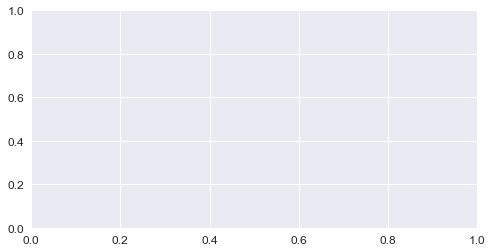

In [35]:
#i+=1
train_model(
    model, 
    dataset, 
    None,#model_path + name_folder,
    learning_rate=1e-4,
    log_dir=None#"./logs/H/" + name + "_" + "x".join(list(map(str, structure))) + "_" + str(i)
)

In [41]:
err = np.mean(((AbstractDataset.denormalize(
    model.predict(dataset.testing[0]), 
    dataset.y_mean,
    dataset.y_std
) - AbstractDataset.denormalize(
    dataset.testing[1],
    dataset.y_mean, 
    dataset.y_std
))**2))#.shape

print("err = {:1.2E}".format(err))

err = 2.18E-04
